# Baseline Models and Linear Regression

Table of Contents :
- [Baseline Model ( Dummy Model )](#DRM)
- [Linear Regression Model](#LRM) 
- [Permutation Test ( Model Evaluation )](#PT)
- [Comparision of Models](#COM)
- [Finding the Best Model](#FTBM)
- [Appendix](#APPENDIX)

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate, cross_val_score, learning_curve, ShuffleSplit, permutation_test_score

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## <a id="LRM"></a> Linear Regression Model - `LinearRegression()` 
We'll be using it after scaling the data with `StandardScaler` in a `Pipeline` 

In [6]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

In [12]:
print("Shape of feature matrix is : ", features.shape)
print("Shape of label vector is : ", labels.shape)

Shape of feature matrix is :  (20640, 8)
Shape of label vector is :  (20640,)


In [17]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)

In [23]:
print("No of training samples : ", train_features.shape[0])
print("No of testing samples : ", test_features.shape[0])

No of training samples :  15480
No of testing samples :  5160


The **pipeline** takes a **list of (name, transform) tuples (implementing `fit`/`transform`) that are chained**, in the order in which they are chained, with the last object an estimator.

In [24]:
lin_reg_pipeline = Pipeline([
    ("feature_scaling", StandardScaler()),
    ('lin_reg', LinearRegression())
])

In [31]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

lin_reg_cv_results = cross_validate(lin_reg_pipeline, train_features, train_labels, cv=shuffle_split_cv, scoring='neg_mean_absolute_error', return_train_score=True, return_estimator=True)

In [60]:
lin_reg_error = pd.Series(-1 * lin_reg_cv_results['test_score'], name='Dummy regression error')

res = pd.DataFrame(lin_reg_cv_results)
res["Linear Regression Error"] = -res["test_score"]
res

,fit_time,score_time,estimator,test_score,train_score,Linear Regression Error
0,0.024830,0.005049,"(StandardScaler(), LinearRegression())",-0.515917,-0.534195,0.515917
1,0.017644,0.003988,"(StandardScaler(), LinearRegression())",-0.531678,-0.528976,0.531678
2,0.014957,0.002990,"(StandardScaler(), LinearRegression())",-0.540924,-0.525882,0.540924
3,0.014972,0.002977,"(StandardScaler(), LinearRegression())",-0.528676,-0.530704,0.528676
4,0.013955,0.003994,"(StandardScaler(), LinearRegression())",-0.549056,-0.524884,0.549056
5,0.016963,0.003968,"(StandardScaler(), LinearRegression())",-0.525526,-0.531588,0.525526
6,0.017894,0.003986,"(StandardScaler(), LinearRegression())",-0.528934,-0.530528,0.528934
7,0.015947,0.004028,"(StandardScaler(), LinearRegression())",-0.535021,-0.528397,0.535021
8,0.014904,0.002989,"(StandardScaler(), LinearRegression())",-0.519714,-0.532270,0.519714
9,0.017941,0.003985,"(StandardScaler(), LinearRegression())",-0.542722,-0.526288,0.542722


## <a id="DRM"></a> Dummy Regression Model - `DummyRegressor()`

Regressor that makes predictions using simple rules. `strategy` parameter is used to generate predictions :

- `mean` : always predicts the mean of the training set
- `median` : always predicts the median of the training set
- `quantile` : always predicts a specified quantile of the training set, provided with the quantile parameter
- `constant` : always predicts a constant value that is provided by the user



In [63]:
def dummy_regressor_baseline(strategy, constant_val=None, quantile_val=None):
    baseline = DummyRegressor(strategy=strategy, constant=constant_val, quantile=quantile_val)
    baseline_cv_results = cross_validate(baseline, train_features, train_labels, cv=shuffle_split_cv, scoring='neg_mean_absolute_error')
    return pd.Series(-1 * baseline_cv_results['test_score'], name='Dummy regression error')

baseline_median_cv_results_error = dummy_regressor_baseline(strategy='median')
baseline_mean_cv_results_error = dummy_regressor_baseline(strategy='mean')
baseline_constant_cv_results_error = dummy_regressor_baseline(strategy='constant', constant_val=2)  # Predicts all labels as 2
baseline_quantile_cv_results_error = dummy_regressor_baseline(strategy='quantile', quantile_val=0.55)

dummy_error_df = pd.concat([baseline_median_cv_results_error,
                           baseline_mean_cv_results_error,
                           baseline_constant_cv_results_error,
                           baseline_quantile_cv_results_error], axis=1)

dummy_error_df.columns = ['Median', 'Mean', 'Constant', 'Quantile'] # The cross validation errors

Text(0.5, 0, 'Error Rate / 100')

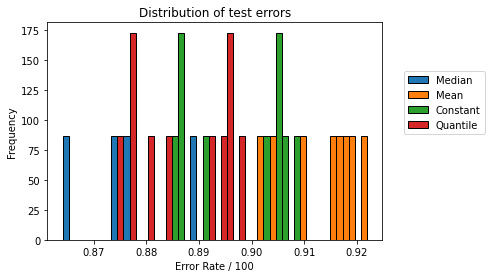

In [72]:
dummy_error_df.plot.hist(bins=50, edgecolor="black", density=True)
plt.legend(bbox_to_anchor=(1.05,0.8), loc='upper left')
plt.title("Distribution of test errors")
plt.xlabel("Error Rate / 100")

## <a id="PT"></a>Pemutation Test - `permutation_test_score()`
- It is a **model evalutaion technique**
- This is a method like `cross_validation` and **it gives a performance metric of the model**. It is 
- Permutes the target to generate randomized data and computes empirical p-value against the null hypothesis that features and targets are independent.


In [69]:
score, permutation_score, pvalue = permutation_test_score(lin_reg_pipeline, train_features, train_labels, cv=shuffle_split_cv,
                                                         scoring='neg_mean_absolute_error', n_permutations=30)

permutation_error = pd.Series(-1 * permutation_score, name='Permuted error')

In [54]:
permutation_score

array([-0.91446539, -0.91608713, -0.91501122, -0.91112203, -0.91326112,
       -0.91428719, -0.91694297, -0.90660687, -0.90873595, -0.91546138,
       -0.9084695 , -0.91174023, -0.91857102, -0.91467076, -0.90396709,
       -0.91239289, -0.91095499, -0.91729623, -0.90529415, -0.91436609,
       -0.91993036, -0.91661883, -0.91104746, -0.91563156, -0.91014294,
       -0.91526135, -0.90680247, -0.90796435, -0.91032999, -0.91545574])

## <a id="COM"></a>Comparision of Models

Text(0.5, 0, 'Error Rate / 100')

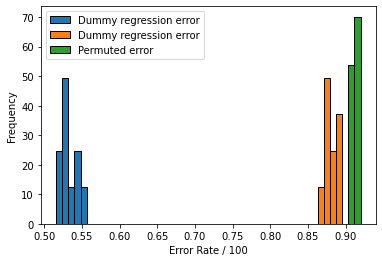

In [74]:
error_df = pd.concat([lin_reg_error, baseline_median_cv_results_error, permutation_error], axis=1)
error_df.plot.hist(bins=50, density=True, edgecolor='black')
plt.legend(loc='best')
plt.xlabel("Error Rate / 100")

#### Clearly our model - `LinearRegression()` is better since it has a lower error. So, we'll imporve it further.

## `LinearRegression()`

In [83]:
lin_reg_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                             ("lin_reg", LinearRegression())])
lin_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('lin_reg', LinearRegression())])

In [85]:
print("Intercept (w0) : ", lin_reg_pipeline[-1].intercept_)
print("Weight vector (w1, w2, ..., wm) : ", lin_reg_pipeline[-1].coef_)

Intercept (w0) :  2.0703489205426377
Weight vector (w1, w2, ..., wm) :  [ 0.85210815  0.12065533 -0.30210555  0.34860575 -0.00164465 -0.04116356
 -0.89314697 -0.86784046]


See Appendix to know more about the `.score()` function

In [102]:
test_score = lin_reg_pipeline.score(test_features, test_labels)
print("Model performance on test set: ", test_score)

train_score = lin_reg_pipeline.score(train_features, train_labels)
print("Model performance on train set : ", train_score)

Model performance on test set:  0.5910509795491352
Model performance on train set :  0.609873031052925


$\textbf R^2$ score here is low. This points to **underfitting**. Let's confirm it using `cross_validation` score

In [105]:
lin_reg_score = cross_val_score(lin_reg_pipeline, train_features, train_labels, scoring='neg_mean_squared_error', cv=shuffle_split_cv)

print(lin_reg_score) # This is a list of 10 scores, since the Shuffle split performed 10 splits.
print("\nScore of linear regression model on test set : \n ", lin_reg_score.mean(), "+(or)-", lin_reg_score.std())

[-0.50009976 -0.52183352 -0.55931218 -0.52110499 -0.56059203 -0.50510767
 -0.52386194 -0.54775518 -0.5007161  -0.54713448]

Score of linear regression model on test set : 
  -0.5287517875396764 +(or)- 0.022232904569798685


So clearly, the **accuracy (`lin_reg_score`) of our model is low**

In [107]:
lin_reg_mse = -lin_reg_score
print("Mean Squared Error (MSE) of Linear Regression Model on test set :\n", lin_reg_mse.mean(), "+(or)-", lin_reg_mse.std())

Mean Squared Error (MSE) of Linear Regression Model on test set :
 0.5287517875396764 +(or)- 0.022232904569798685


Alternatively, use **`cross_validate`** API. **This can return the models trained on each fold with train error for that fold.**

In [113]:
lin_reg_cv_results = cross_validate(lin_reg_pipeline, train_features, train_labels, cv=shuffle_split_cv, 
                                    scoring='neg_mean_squared_error', return_train_score=True, return_estimator=True)

In [114]:
lin_reg_cv_results # There are 10 values for each key, one for each fold.

{'fit_time': array([0.02038932, 0.01601696, 0.01595187, 0.01490927, 0.01594782,
        0.01395392, 0.01495099, 0.01602912, 0.01395965, 0.01500893]),
 'score_time': array([0.00451183, 0.00396419, 0.00299335, 0.00400209, 0.00398612,
        0.00437999, 0.0029943 , 0.0029881 , 0.00397801, 0.00396895]),
 'estimator': [Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('featu

In [117]:
train_error = -1 * lin_reg_cv_results['train_score']
test_error = -1 * lin_reg_cv_results['test_score']

print("Mean Squared Error (MSE) of Linear Regression Model on training set :\n", train_error.mean(), "+(or)-", train_error.std())
print("\nMean Squared Error (MSE) of Linear Regression Model on test set :\n", test_error.mean(), "+(or)-", test_error.std())

Mean Squared Error (MSE) of Linear Regression Model on training set :
 0.5186840759388986 +(or)- 0.005552249067390957

Mean Squared Error (MSE) of Linear Regression Model on test set :
 0.5287517875396764 +(or)- 0.022232904569798685


In [122]:
train_features.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

<AxesSubplot:>

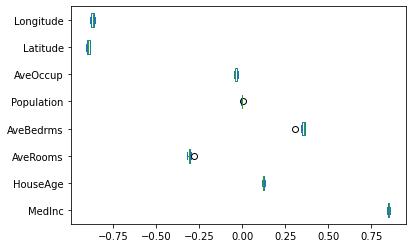

In [157]:
# We want to store the LinearRegression estimator's weight vector at each step. (estimator[-1].coef_) gives the LinearRegression estimator's weight vector 

coefs = [est[-1].coef_ for est in lin_reg_cv_results['estimator']]
weights_df = pd.DataFrame(coefs, columns=train_features.columns)

weights_df.plot.box(vert=False)

In [125]:
weights_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.852153,0.122770,-0.304384,0.353528,-0.001576,-0.037059,-0.894011,-0.869753
std,0.005763,0.004312,0.010998,0.018044,0.003254,0.008582,0.009975,0.009097
min,0.843517,0.117394,-0.318971,0.307474,-0.005787,-0.047584,-0.908058,-0.884206
25%,0.848871,0.119895,-0.310778,0.349715,-0.002688,-0.042486,-0.901411,-0.876542
50%,0.852711,0.121592,-0.305795,0.360139,-0.002063,-0.042325,-0.895370,-0.869631
75%,0.854743,0.125520,-0.302980,0.364646,-0.000350,-0.027562,-0.883967,-0.862110
max,0.861659,0.130560,-0.278426,0.367952,0.005297,-0.026331,-0.881884,-0.857844


Note that variance of the features AveRooms and AveBedrms are higher than the others. Also, Population seems to have outliers, since the 75% percentile is significantly different from the max value.

## <a id="FTBM"></a>Finding The Best Model
In order to the find the best model, locate the estimator among all the folds that returned the least test error

In [137]:
print("Test error : ", test_error)
print("\nIndex of minimum value in test error : ", np.argmin(test_error))

selected_model = lin_reg_cv_results['estimator'][np.argmin(test_error)]
# print("\nSelected Model : ", selected_model) to see the selected model. ll the models are here lin_reg_pipeline, we can't tell which was chosen. So, we print the last step ( here, the intercept and the weight vector of the linearRegression ) 

print("\nIntercept (w0) : ", selected_model[-1].intercept_)
print("\nWeight vector (w1, w2, ..., wm) : \n", selected_model[-1].coef_)

Test error :  [0.50009976 0.52183352 0.55931218 0.52110499 0.56059203 0.50510767
 0.52386194 0.54775518 0.5007161  0.54713448]

Index of minimum value in test error :  0

Intercept (w0) :  2.0779898917958657

Weight vector (w1, w2, ..., wm) : 
 [ 8.44324888e-01  1.18463901e-01 -3.04619574e-01  3.56620503e-01
  1.74458509e-04 -4.23964612e-02 -8.96045642e-01 -8.68906479e-01]


Let us see how the actual and predicted labels for the training set differs

In [159]:
from sklearn.model_selection import cross_val_predict

Text(0.5, 1.0, 'Mean squared error = 0.52')

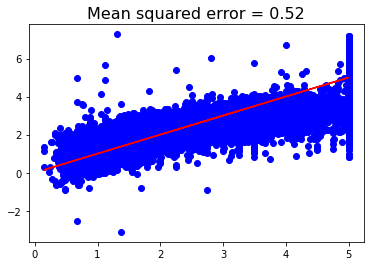

In [151]:
cv_predictions = cross_val_predict(lin_reg_pipeline, train_features, train_labels)
plt.scatter(train_labels, cv_predictions, color='blue')
plt.plot(train_labels, train_labels, 'r-')
mse_cv = mean_squared_error(train_labels, cv_predictions)
plot_title = "Mean squared error = {:.2f}".format(mse_cv)
plt.title(plot_title, size=16)

Once the final model has been selected, use it to predict on test_features

In [154]:
test_predictions_cv = selected_model.predict(test_features)
test_predictions_cv[:5]

array([0.73548515, 1.7725621 , 2.70011199, 2.83716602, 2.60743151])

Let us compare the above with the predictions on same test_features we built without cross-validation :

In [156]:
test_predictions = lin_reg_pipeline.predict(test_features)
test_predictions[:5]

array([0.72412832, 1.76677807, 2.71151581, 2.83601179, 2.603755  ])

####  Evaluation on the selected model

In [161]:
test_score = selected_model.score(test_features, test_labels)
print("Model performance on test set: ", test_score)

train_score = selected_model.score(train_features, train_labels)
print("Model performance on train set : ", train_score)

Model performance on test set:  0.5923577635319088
Model performance on train set :  0.6098001134259827


#### Evaluation on original model 
The one wiithout cross-validation. This was calculated before as well.

In [160]:
test_score = lin_reg_pipeline.score(test_features, test_labels)
print("Model performance on test set: ", test_score)

train_score = lin_reg_pipeline.score(train_features, train_labels)
print("Model performance on train set : ", train_score)

Model performance on test set:  0.5910509795491352
Model performance on train set :  0.609873031052925


#### Note that the test scores are marginally ( slightly ) higher with cross validation

### Learning Curve
It determines cross-validated training and test scores for different training
set sizes.

In [168]:
result = learning_curve(lin_reg_pipeline, train_features, train_labels, cv=shuffle_split_cv, scoring='neg_mean_squared_error', 
                        n_jobs=-1, return_times=True, train_sizes=np.linspace(0.2, 1.0, 10))
                        
(train_sizes, train_scores, test_scores, fit_times, score_times) = result

# for (size, train_score, test_score) in zip(train_sizes, train_scores, test_scores):
#     print("For a training set with", size, "samples : \n",
#           "\nTrain score is : \n", [round(each,3) for each in train_score],
#           "\nTest score is : \n", [round(each,3) for each in test_score])

## <a id="APPENDIX"></a>Appendix

**NOTE :** `.score()` function returns the $ \textbf R^2 $ score which is :

\begin{align} R^2&=1-\frac{\text{sum squared regression (SSR)}}{\text{total sum of squares (SST)}},\\ &=1-\frac{\sum({y_i}-\hat{y_i})^2}{\sum(y_i-\bar{y})^2}. \end{align}

where $\bar y$ is the mean and $\hat y_{i}$ is the predicted value for the $i^{th}$ data

Rule of thumb : **Higher the better**

<br>

<br>

For a better understanding, see below :


<img src="R2_Interpretation.png"></img>